In [1]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

from tqdm.auto import tqdm



In [2]:
import torchvision
import torchvision.models.detection as detection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

# Send train=True for training transforms and False for val/test transforms
def get_transform():
    transform = [transforms.ToTensor()]
    return transforms.Compose(transform)


In [3]:
from datasets import KittiTorch

# Assuming KittiTorch and utils are defined/imported correctly
dataset = KittiTorch(root='../data', download=True, transform=get_transform())

# Print initial dataset size
print("Initial dataset size:", len(dataset))

# Seed and random permutation
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Calculate split sizes
train_split = 0.8
val_split = 0.1  # 10% for validation
test_split = 0.1  # 10% for test

# Calculate indices for splits
train_size = int(len(dataset) * train_split)
val_size = int(len(dataset) * val_split)
test_size = len(dataset) - train_size - val_size  # To ensure full coverage

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create dataset subsets
dataset_train = torch.utils.data.Subset(dataset, train_indices)
dataset_val = torch.utils.data.Subset(dataset, val_indices)
dataset_test = torch.utils.data.Subset(dataset, test_indices)

# Define batch size
batch_size = 8

# Data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn,
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn,
)

# Print sizes of datasets to confirm splits
print("Training set size:", len(dataset_train))
print("Validation set size:", len(dataset_val))
print("Testing set size:", len(dataset_test))


Initial dataset size: 7481
Training set size: 5984
Validation set size: 748
Testing set size: 749


In [4]:
# Check if GPU is available
torch.cuda.empty_cache()
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  - {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  - Memory Total: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
        print(f"  - Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  - Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
else:
    print("No GPU is available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3070
  - 0.00 GB
  - Memory Cached: 0.00 GB
  - Memory Total: 7.78 GB
  - Compute Capability: (8, 6)
  - Multiprocessors: 46


In [5]:
def get_object_detection_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


#   for param in model.backbone.parameters():
#         param.requires_grad = False
        
  return model

In [6]:
model = get_object_detection_model(10)


model.eval()
model.to('cuda')

prediction = model(dataset[0][0].unsqueeze(0).to('cuda'))

In [7]:
prediction

[{'boxes': tensor([[9.9996e+02, 2.4661e+02, 1.0571e+03, 3.5175e+02],
          [9.9996e+02, 2.6713e+02, 1.0208e+03, 3.4261e+02],
          [2.9890e+02, 2.1631e+02, 3.3380e+02, 2.3282e+02],
          [3.0018e+02, 2.0941e+02, 3.3971e+02, 2.2590e+02],
          [3.2707e+02, 2.1988e+02, 3.7300e+02, 2.3914e+02],
          [2.9550e+02, 2.1464e+02, 3.1439e+02, 2.5458e+02],
          [3.2518e+02, 2.0986e+02, 3.4178e+02, 2.3749e+02],
          [9.4923e+02, 2.2222e+02, 9.6903e+02, 2.7861e+02],
          [3.2820e+02, 2.0812e+02, 3.4443e+02, 2.6975e+02],
          [3.0748e+02, 2.0860e+02, 3.3803e+02, 2.4526e+02],
          [9.3872e+02, 2.3165e+02, 9.6023e+02, 2.8196e+02],
          [9.1278e+02, 2.2443e+02, 9.3264e+02, 2.7672e+02],
          [8.2430e+02, 2.1135e+02, 8.6939e+02, 2.6695e+02],
          [3.1549e+02, 2.1224e+02, 3.3336e+02, 2.7266e+02],
          [9.8057e+02, 2.3752e+02, 1.0018e+03, 2.8152e+02],
          [3.3378e+02, 2.2617e+02, 3.4983e+02, 2.8796e+02],
          [3.3160e+02, 2.0325e+

In [8]:
import pprint as pp

image, target = dataset[0]
print(image)
print(type(target))
pp.pprint(target)


print("data loader part")
for images, targets in data_loader_train:
    print(len(images))
    print(images[0].shape)
    print(type(targets))
    pp.pprint(targets)
    break


tensor([[[0.0667, 0.0627, 0.0980,  ..., 0.1451, 0.1373, 0.1412],
         [0.0667, 0.0549, 0.0941,  ..., 0.1451, 0.1373, 0.1373],
         [0.0667, 0.0706, 0.0706,  ..., 0.1333, 0.1255, 0.1176],
         ...,
         [0.0745, 0.0667, 0.0627,  ..., 0.0941, 0.0784, 0.0784],
         [0.0471, 0.0471, 0.0549,  ..., 0.0784, 0.0824, 0.0824],
         [0.0510, 0.0549, 0.0549,  ..., 0.0863, 0.0863, 0.0784]],

        [[0.0863, 0.0941, 0.1137,  ..., 0.1137, 0.0941, 0.0667],
         [0.0745, 0.0902, 0.1098,  ..., 0.1137, 0.0980, 0.0706],
         [0.0627, 0.0627, 0.0824,  ..., 0.1137, 0.0902, 0.0667],
         ...,
         [0.0902, 0.0863, 0.0863,  ..., 0.0980, 0.1020, 0.1059],
         [0.0824, 0.0745, 0.0706,  ..., 0.0980, 0.0980, 0.1059],
         [0.0784, 0.0706, 0.0667,  ..., 0.1176, 0.1137, 0.1176]],

        [[0.0706, 0.1098, 0.1294,  ..., 0.0902, 0.0824, 0.0588],
         [0.0627, 0.0784, 0.0941,  ..., 0.0980, 0.0824, 0.0549],
         [0.0627, 0.0745, 0.0824,  ..., 0.1059, 0.0863, 0.

In [9]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

lr = 10e-3

# Define the list of classes
class_list = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
num_classes = len(class_list)  # one class (class 0) is dedicated to the "background"

# Assume get_object_detection_model is defined and returns a model instance
model = get_object_detection_model(num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer (using Adam here)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.Adam(params, lr=lr)  # Set a learning rate, modify as needed

# sgd optmizer
optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

# Optionally, you can set other parameters like betas and eps
# optimizer = optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)

cuda


In [10]:
torch.cuda.empty_cache()

In [11]:
import wandb

# Login to WandB (only needed if you haven't configured automatic login)
wandb.login()

num_epochs = 5

# Initialize a new WandB run
wandb.init(project="portalcut",
            entity='231n-augmentation', 
            notes="2024-05-30-kitti-test1-fasterrcnn_resnet50_fpn_v2_scratch_50ep_v2",
            
            config={
                "learning_rate": lr,
                "epochs": num_epochs,
                "batch_size": batch_size,
                "optimizer": "Adam",
            })


config = wandb.config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sazzadi14. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: sazzadi14 (231n-augmentation). Use `wandb login --relogin` to force relogin


In [12]:
# training for 5 epochs
import math
import sys
import time
import utils

data_loader = data_loader_train

scaler = None  # Define the "scaler" variable

model_save_path = './models/test1_v1.pth'
print_freq = 10
# Training loop

# Assume we have an existing setup
for epoch in range(num_epochs):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"
    start_time = time.time()

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Log metrics to WandB
        wandb.log({
            **loss_dict,
            "epoch": epoch,
            "loss": loss_value,
            "learning_rate": optimizer.param_groups[0]["lr"]
        })
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # After each epoch
    # lr_scheduler.step()
    break



# wandb.log_artifact(model)
torch.save(model.state_dict(), model_save_path)

# model.to_onnx()
# wandb.save("model.onnx")


# Finish WandB run
wandb.finish()

Epoch: [0]  [  0/748]  eta: 0:09:26  lr: 0.010000  loss: 3.1444 (3.1444)  loss_classifier: 2.6006 (2.6006)  loss_box_reg: 0.4474 (0.4474)  loss_objectness: 0.0364 (0.0364)  loss_rpn_box_reg: 0.0600 (0.0600)  time: 0.7575  data: 0.0720  max mem: 4947
Epoch: [0]  [ 10/748]  eta: 0:07:56  lr: 0.010000  loss: 1.1404 (1.4668)  loss_classifier: 0.5203 (0.7627)  loss_box_reg: 0.4942 (0.5650)  loss_objectness: 0.0683 (0.0758)  loss_rpn_box_reg: 0.0493 (0.0633)  time: 0.6455  data: 0.0729  max mem: 5102
Epoch: [0]  [ 20/748]  eta: 0:07:43  lr: 0.010000  loss: 1.0889 (1.2600)  loss_classifier: 0.4439 (0.5953)  loss_box_reg: 0.4773 (0.5196)  loss_objectness: 0.0737 (0.0766)  loss_rpn_box_reg: 0.0608 (0.0685)  time: 0.6307  data: 0.0712  max mem: 5102
Epoch: [0]  [ 30/748]  eta: 0:07:34  lr: 0.010000  loss: 0.8539 (1.0964)  loss_classifier: 0.3202 (0.4957)  loss_box_reg: 0.3770 (0.4609)  loss_objectness: 0.0657 (0.0698)  loss_rpn_box_reg: 0.0696 (0.0700)  time: 0.6271  data: 0.0693  max mem: 5102


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▅▃▄▆▄▃▂▃▂▅▃▂▃▁▂▂▃▃▂▁▃▃▃▃▁▄▁▂▂▁▂▂▂▂▂▁▁▂█▁
loss_box_reg,█▃▄▆▅▄▃▅▂▄▄▃▄▂▃▃▄▅▂▁▅▄▃▅▂▂▂▃▂▁▃▂▃▁▂▂▂▂▂▂
loss_classifier,█▄▅▆▅▄▃▅▂▄▃▃▄▁▃▃▄▃▂▁▅▄▄▃▂▃▂▃▂▂▃▁▃▂▂▂▁▁▂▁
loss_objectness,▂▂▂▄▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁█▁
loss_rpn_box_reg,▁▂▄▃▃▂▁▁▁▅▃▂▂▁▁▂▁▃▂▁▁▁▃▂▂▄▂▂▂▁▂▃▂▂▃▁▂▃█▂
epoch,0
learning_rate,0.01
loss,0.42861
loss_box_reg,0.19206


In [13]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  - {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  - Memory Total: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
        print(f"  - Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  - Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
else:
    print("No GPU is available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3070
  - 1.03 GB
  - Memory Cached: 6.34 GB
  - Memory Total: 7.78 GB
  - Compute Capability: (8, 6)
  - Multiprocessors: 46


In [14]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
dataset_test[0]

(tensor([[[0.6588, 0.6941, 0.6784,  ..., 0.1647, 0.1647, 0.1686],
          [0.6549, 0.6824, 0.6667,  ..., 0.1686, 0.1725, 0.1725],
          [0.7255, 0.7333, 0.6941,  ..., 0.1686, 0.1686, 0.1647],
          ...,
          [0.4863, 0.4824, 0.5137,  ..., 0.0627, 0.0588, 0.0549],
          [0.4902, 0.4824, 0.5216,  ..., 0.0627, 0.0588, 0.0549],
          [0.4549, 0.4471, 0.4784,  ..., 0.0588, 0.0588, 0.0588]],
 
         [[0.9608, 0.8549, 0.7804,  ..., 0.2118, 0.2118, 0.2157],
          [0.9255, 0.8196, 0.7569,  ..., 0.2118, 0.2157, 0.2118],
          [0.9412, 0.8431, 0.7686,  ..., 0.2196, 0.2196, 0.2196],
          ...,
          [0.4667, 0.4706, 0.4902,  ..., 0.0510, 0.0510, 0.0510],
          [0.4863, 0.5020, 0.4824,  ..., 0.0471, 0.0471, 0.0471],
          [0.5020, 0.4980, 0.4667,  ..., 0.0431, 0.0431, 0.0431]],
 
         [[0.9294, 0.7608, 0.7569,  ..., 0.2510, 0.2588, 0.2588],
          [0.9608, 0.7765, 0.7529,  ..., 0.2549, 0.2627, 0.2627],
          [0.9882, 0.8000, 0.7373,  ...,

In [16]:
# image = dataset_test[9][0]

# input_tensor = image.unsqueeze(0).to('cuda')
# predictions = model(input_tensor)

# predictions

1
1
1
1
2
1
1
1
1
3
1
8
1
1
3
2
1
1
1
1
1
9
2
1
1
2
9
2
1
9
8
9
1
1
1
9
7
6
1
1
1
1
1
9
1
9
1
9
3
8
8
1
1
1
9
1


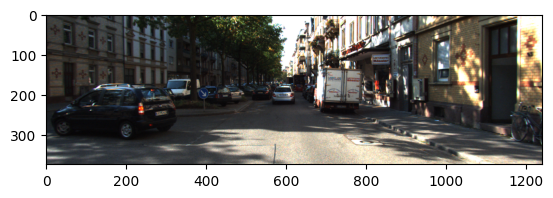

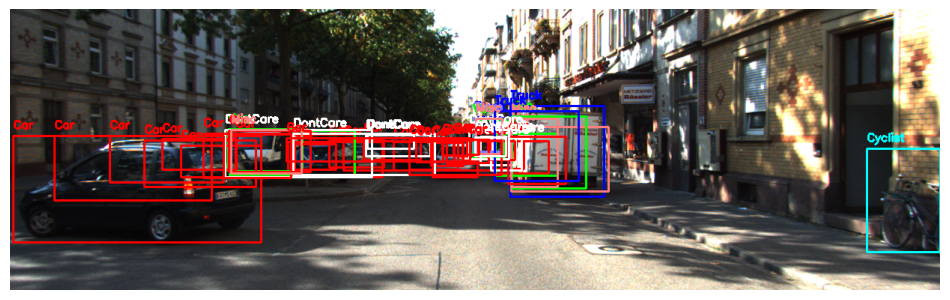

In [17]:
# Write the code that saves up the model from the internet and tests it
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np

image = dataset_test[9][0]
# Load the model
# model.load_state_dict(torch.load(model_save_path))

# Ensure your model is on the GPU
# model = model.to('cuda')

# Move the input tensor to the GPU
input_tensor = image.unsqueeze(0).to('cuda')


model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    predictions = model(input_tensor)


import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_with_boxes(image, boxes, labels, label_names):
    # Convert tensor image to numpy array
    image = image.cpu().numpy().transpose((1, 2, 0))
    # Scale the image's pixel values to [0, 255]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
    # Convert the image to CPU and NumPy format for plotting


    # Define colors for different classes
    colors = {
        'Car': (255, 0, 0), 'Van': (0, 255, 0), 'Truck': (0, 0, 255),
        'Pedestrian': (255, 255, 0), 'Person_sitting': (255, 0, 255), 'Cyclist': (0, 255, 255),
        'Tram': (127, 127, 255), 'Misc': (255, 127, 127), "Don'tCare": (127, 127, 127)
    }

    # Draw boxes and labels
    for box, label in zip(boxes, labels):
        box = box.cpu().numpy().astype(int)
        label = int(label.cpu())
        box = box.astype(int)
        print(label)
        label_text = label_names[label]
        color = colors.get(label_text, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label
        cv2.putText(image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

# Sample call to the function

target = predictions[0]
# image = dataset[0][0]
plt.imshow(image.permute(1, 2, 0))
# This assumes `image` is a tensor from the dataset, `boxes` is a tensor of bounding boxes, and `labels` is a tensor of label indices
visualize_image_with_boxes(image, target['boxes'], target['labels'], label_names)


In [18]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.ops import box_iou
from collections import defaultdict

# Load the model

# model = get_object_detection_model(10)
# model.load_state_dict(torch.load(model_save_path))
# model = model.to('cuda')
# model.eval()

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

def compute_iou(boxes1, boxes2):
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.tensor([]).to(boxes1.device)
    boxes1 = boxes1.to('cuda')
    boxes2 = boxes2.to('cuda')
    ious = box_iou(boxes1, boxes2)
    return ious

def evaluate_model(model, dataset, label_names, iou_threshold=0.5):
    all_true_boxes = []
    all_pred_boxes = []
    all_true_labels = []
    all_pred_labels = []

    for idx in range(len(dataset)):
        image, target = dataset[idx]
        input_tensor = image.unsqueeze(0).to('cuda')
        
        with torch.no_grad():
            predictions = model(input_tensor)[0]
        
        true_boxes = target['boxes'].to('cuda')
        true_labels = target['labels'].to('cuda')
        pred_boxes = predictions['boxes'].to('cuda')
        pred_labels = predictions['labels'].to('cuda')

        all_true_boxes.append(true_boxes)
        all_pred_boxes.append(pred_boxes)
        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    iou_scores = []
    for true_boxes, pred_boxes in zip(all_true_boxes, all_pred_boxes):
        iou_scores.append(compute_iou(true_boxes, pred_boxes))

    mean_iou = torch.mean(torch.stack([torch.mean(iou) for iou in iou_scores if iou.numel() > 0]))
    print(f"Mean IoU: {mean_iou:.4f}")

    # Compute mAP (mean Average Precision)
    aps = []
    for i, label_name in enumerate(label_names):
        if label_name == "Background":
            continue
        
        true_positives = []
        false_positives = []
        num_gt = 0

        for true_boxes, true_labels, pred_boxes, pred_labels in zip(all_true_boxes, all_true_labels, all_pred_boxes, all_pred_labels):
            gt_boxes = true_boxes[true_labels == i]
            pred_boxes = pred_boxes[pred_labels == i]
            num_gt += len(gt_boxes)

            if len(pred_boxes) == 0:
                continue
            
            ious = compute_iou(gt_boxes, pred_boxes)
            if ious.numel() == 0:
                continue
            true_positive = ious.max(dim=0)[0] > iou_threshold
            false_positive = ~true_positive

            true_positives.extend(true_positive.cpu().numpy())
            false_positives.extend(false_positive.cpu().numpy())
        
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recalls = tp_cumsum / (num_gt + 1e-6)

        ap = np.trapz(precisions, recalls)
        aps.append(ap)

        print(f"AP for {label_name}: {ap:.4f}")

    mAP = np.mean(aps)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Example usage
evaluate_model(model, dataset_test, label_names)


Mean IoU: 0.1334
AP for Car: 0.5016
AP for Van: 0.3859
AP for Truck: 0.5999
AP for Pedestrian: 0.3617
AP for Person_sitting: 0.2740
AP for Cyclist: 0.4916
AP for Tram: 0.5870
AP for Misc: 0.2303
AP for DontCare: 0.1125
Mean Average Precision (mAP): 0.3938


In [19]:
evaluate_model(model, dataset, label_names)

Mean IoU: 0.1277
AP for Car: 0.5005
AP for Van: 0.3691
AP for Truck: 0.5085
AP for Pedestrian: 0.3538
AP for Person_sitting: 0.4603
AP for Cyclist: 0.4400
AP for Tram: 0.5115
AP for Misc: 0.3046
AP for DontCare: 0.1320
Mean Average Precision (mAP): 0.3978


In [27]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.ops import box_iou
from collections import defaultdict

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

def compute_iou(boxes1, boxes2):
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.tensor([]).to(boxes1.device)
    boxes1 = boxes1.to('cuda')
    boxes2 = boxes2.to('cuda')
    ious = box_iou(boxes1, boxes2)
    return ious

def calculate_precision_recall_f1(pred_boxes, true_boxes, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    for pred_box in pred_boxes:
        if any(compute_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0)) >= iou_threshold for true_box in true_boxes):
            tp += 1
        else:
            fp += 1

    fn = len(true_boxes) - tp
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

def calculate_map(pred_boxes, true_boxes, iou_thresholds=np.linspace(0.5, 0.95, 10)):
    aps = []
    for iou_threshold in iou_thresholds:
        precision, recall, _ = calculate_precision_recall_f1(pred_boxes, true_boxes, iou_threshold)
        aps.append(precision * recall)

    return np.mean(aps)

def evaluate_model(model, dataset, label_names, iou_threshold=0.5):
    all_true_boxes = []
    all_pred_boxes = []
    all_true_labels = []
    all_pred_labels = []

    model.eval()
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        input_tensor = image.unsqueeze(0).to('cuda')
        
        with torch.no_grad():
            predictions = model(input_tensor)[0]
        
        true_boxes = target['boxes'].to('cuda')
        true_labels = target['labels'].to('cuda')
        pred_boxes = predictions['boxes'].to('cuda')
        pred_labels = predictions['labels'].to('cuda')
        
        # Create masks for excluding 'Background' and 'DontCare' labels
        exclude_labels = torch.tensor([label_names.index('Background'), label_names.index('DontCare')], device='cuda')
        relevant_true_mask = ~(true_labels.unsqueeze(1) == exclude_labels).any(1)
        relevant_pred_mask = ~(pred_labels.unsqueeze(1) == exclude_labels).any(1)

        filtered_true_boxes = true_boxes[relevant_true_mask]
        filtered_true_labels = true_labels[relevant_true_mask]
        filtered_pred_boxes = pred_boxes[relevant_pred_mask]
        filtered_pred_labels = pred_labels[relevant_pred_mask]

        all_true_boxes.append(filtered_true_boxes)
        all_pred_boxes.append(filtered_pred_boxes)
        all_true_labels.append(filtered_true_labels)
        all_pred_labels.append(filtered_pred_labels)


    # Calculate IoU
    iou_scores = []
    for true_boxes, pred_boxes in zip(all_true_boxes, all_pred_boxes):
        iou_scores.append(compute_iou(true_boxes, pred_boxes))

    mean_iou = torch.mean(torch.stack([torch.mean(iou) for iou in iou_scores if iou.numel() > 0]))
    print(f"Mean IoU: {mean_iou:.4f}")

    # Calculate Precision, Recall, F1-Score, and mAP
    aps = []
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_samples = 0

    for i, label_name in enumerate(label_names):
        if label_name == "Background" or label_name == "DontCare":
            continue
        
        true_positives = []
        false_positives = []
        num_gt = 0

        for true_boxes, true_labels, pred_boxes, pred_labels in zip(all_true_boxes, all_true_labels, all_pred_boxes, all_pred_labels):
            gt_boxes = true_boxes[true_labels == i]
            pred_boxes = pred_boxes[pred_labels == i]
            num_gt += len(gt_boxes)

            if len(pred_boxes) == 0:
                continue
            
            ious = compute_iou(gt_boxes, pred_boxes)
            if ious.numel() == 0:
                continue
            true_positive = ious.max(dim=0)[0] > iou_threshold
            false_positive = ~true_positive

            true_positives.extend(true_positive.cpu().numpy())
            false_positives.extend(false_positive.cpu().numpy())
        
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recalls = tp_cumsum / (num_gt + 1e-6)

        ap = np.trapz(precisions, recalls)
        aps.append(ap)

        precision = tp_cumsum[-1] / (tp_cumsum[-1] + fp_cumsum[-1] + 1e-6)
        recall = tp_cumsum[-1] / (num_gt + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        total_precision += precision
        total_recall += recall
        total_f1 += f1
        total_samples += 1

        print(f"AP for {label_name}: {ap:.4f}")

    mAP = np.mean(aps)
    avg_precision = total_precision / total_samples
    avg_recall = total_recall / total_samples
    avg_f1 = total_f1 / total_samples

    # Ensure recall does not exceed 1
    avg_recall = min(avg_recall, 1.0)

    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-Score: {avg_f1:.4f}")

    return mean_iou, avg_precision, avg_recall, avg_f1, mAP

# Example usage
# Assuming model is loaded and dataset_test is prepared
mean_iou, avg_precision, avg_recall, avg_f1, mAP = evaluate_model(model, dataset_test, label_names)


Mean IoU: 0.2046
AP for Car: 0.5016
AP for Van: 0.3859
AP for Truck: 0.5999
AP for Pedestrian: 0.3617
AP for Person_sitting: 0.2740
AP for Cyclist: 0.4916
AP for Tram: 0.5870
AP for Misc: 0.2303
Mean Average Precision (mAP): 0.4290
Average Precision: 0.4244
Average Recall: 1.0000
Average F1-Score: 0.5852


In [23]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.ops import box_iou

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

def compute_iou(boxes1, boxes2):
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.tensor([]).to(boxes1.device)
    return box_iou(boxes1, boxes2)

def evaluate_model(model, dataset, label_names, iou_threshold=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    all_true_boxes = []
    all_pred_boxes = []
    all_true_labels = []
    all_pred_labels = []
    aps = []
    precision_list = []
    recall_list = []
    f1_list = []

    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            predictions = model(image)[0]

        all_true_boxes.append(target['boxes'].to(device))
        all_true_labels.append(target['labels'].to(device))
        all_pred_boxes.append(predictions['boxes'].to(device))
        all_pred_labels.append(predictions['labels'].to(device))

    iou_scores = [compute_iou(t_boxes, p_boxes) for t_boxes, p_boxes in zip(all_true_boxes, all_pred_boxes)]
    mean_iou = torch.mean(torch.cat([torch.mean(iou) for iou in iou_scores if iou.numel() > 0]))

    # Calculate Precision, Recall, F1-Score, and mAP
    for i, label_name in enumerate(label_names):
        if label_name in ["Background", "DontCare"]:
            continue
        true_positives = []
        false_positives = []
        num_gt = 0

        for true_boxes, true_labels, pred_boxes, pred_labels in zip(all_true_boxes, all_true_labels, all_pred_boxes, all_pred_labels):
            mask = true_labels == i
            gt_boxes = true_boxes[mask]
            mask = pred_labels == i
            pred_boxes = pred_boxes[mask]
            num_gt += gt_boxes.size(0)
            
            if gt_boxes.size(0) == 0 or pred_boxes.size(0) == 0:
                continue

            ious = compute_iou(gt_boxes, pred_boxes)
            max_ious, _ = ious.max(dim=0)
            true_positives.append(max_ious > iou_threshold)
            false_positives.append(max_ious <= iou_threshold)

        true_positives = torch.cat(true_positives) if true_positives else torch.tensor([])
        false_positives = torch.cat(false_positives) if false_positives else torch.tensor([])
        tp = true_positives.sum().item()
        fp = false_positives.sum().item()
        fn = num_gt - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (num_gt) if num_gt > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        aps.append(precision * recall)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"AP for {label_name}: {precision * recall:.4f}")

    mAP = np.mean(aps)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-Score: {avg_f1:.4f}")

    return mean_iou, avg_precision, avg_recall, avg_f1, mAP

# Example usage
# Assuming model is loaded and dataset_test is prepared
mean_iou, avg_precision, avg_recall, avg_f1, mAP = evaluate_model(model, dataset_test, label_names)


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
print

Alright I like you code, however, will it work if I send in a dataloader in stead of the dataset, here is how I create dataloader

def get_dataloaders(dataset):
    indices = torch.randperm(len(dataset)).tolist()

    # Calculate split sizes, it should add up to 1
    train_split = 0.8
    val_split = 0.1  # 10% for validation
    test_split = 0.1  # 10% for test

    # Calculate indices for splits
    train_size = int(len(dataset) * train_split)
    val_size = int(len(dataset) * val_split)
    test_size = len(dataset) - train_size - val_size  # To ensure full coverage

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Create dataset subsets
    dataset_train = Subset(dataset, train_indices)
    dataset_val = Subset(dataset, val_indices)
    dataset_test = Subset(dataset, test_indices)

    # Define batch size
    batch_size = 4

    # Data loaders
    train_dataloader = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=utils.collate_fn,
    )

    val_dataloader = DataLoader(
        dataset_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=utils.collate_fn,
    )

    test_dataloader = DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=utils.collate_fn,
    )

    # Print sizes of datasets to confirm splits
    print("Training set size:", len(dataset_train))
    print("Validation set size:", len(dataset_val))
    print("Testing set size:", len(dataset_test))
    
    return train_dataloader, val_dataloader, test_dataloader